In [1]:
import numpy as np
import scipy.io as sciIO
import matplotlib.pyplot as plt
import cupy # CUDA interface for python

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext autotime

In [35]:
a = sciIO.readsav('../TD1.sav')
print(a.keys())

dict_keys(['bx', 'by', 'bz', 'xreg', 'yreg', 'zreg', 'resolution', 'dir'])
time: 165 ms


In [38]:
a.xreg

array([-5,  5], dtype=int16)

time: 3 ms


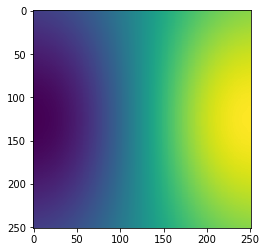

time: 350 ms


In [4]:
# need to be transposed because of the storage toplogy
#Bx = np.transpose(a.twbox[0].bx,(2,1,0)).astype(np.float32)
#By = np.transpose(a.twbox[0].by,(2,1,0)).astype(np.float32)
#Bz = np.transpose(a.twbox[0].bz,(2,1,0)).astype(np.float32)
Bx = np.transpose(a.bx,(2,1,0)).astype(np.float32)
By = np.transpose(a.by,(2,1,0)).astype(np.float32)
Bz = np.transpose(a.bz,(2,1,0)).astype(np.float32)

Bx_gpu = np.zeros(0)
By_gpu = np.zeros(0)
Bz_gpu = np.zeros(0)

plt.imshow(Bz[:,:,250].T) # x,y.z
#plt.imshow(Bz[:,:,0].T)

In [5]:
import numpy
import os

print('compiling kernel')
PWD = os.getcwd()
traceFunc_file = open("TraceBlineAdaptive.cu", "rt")
TraceFunc =cupy.RawModule(code=traceFunc_file.read(),backend='nvcc',options=("-I "+PWD,))#, include_dirs=[PWD], cache_dir='cache',no_extern_c=True)
TraceAllBline = TraceFunc.get_function("TraceAllBline")
#print('kernel compiled')

if Bx_gpu.shape[0]<=1:
    print('transfering B-field to GPU')
    Bx_gpu = cupy.array(Bx)
    By_gpu = cupy.array(By)
    Bz_gpu = cupy.array(Bz)

compiling kernel
transfering B-field to GPU
time: 7.23 s


In [27]:
# prepare variables
BshapeN = np.zeros(3,dtype=np.int32)
BshapeN[:] = Bx.shape
print(BshapeN)
BshapeN = cupy.array(BshapeN)

interp_ratio=4
#x_range = [0,1163]
#y_range = [0,487]
#x_range = [350,670]
#y_range = [200,400]

x_range = [50,200]
y_range = [50,200]


x_i = cupy.linspace(*x_range, np.uint(interp_ratio*(x_range[1]-x_range[0])),dtype=cupy.float32)
y_i = cupy.linspace(*y_range, np.uint(interp_ratio*(y_range[1]-y_range[0])),dtype=cupy.float32)
x_arr,y_arr = cupy.meshgrid(x_i, y_i)

xy_shape = x_arr.shape

x_inp = x_arr.flatten()
y_inp = y_arr.flatten()
z_inp = (cupy.zeros_like(x_inp,cupy.float32)+10)
#z_inp[:] = +23.583333

(x_start,y_start,z_start, x_end,y_end,z_end,
 Bx_start,By_start,Bz_start,Bx_end,By_end,Bz_end, Bx_inp,By_inp,Bz_inp
)=[cupy.zeros(x_inp.shape,dtype=cupy.float32) for _ in range(15)]

(B_flag,flag_start,flag_end)=[cupy.zeros(x_inp.shape,dtype=cupy.int32) for _ in range(3)]

line_len = cupy.zeros(x_inp.shape,cupy.float64)
N        = cupy.array([x_inp.shape[0]],cupy.ulonglong)
s_len    = cupy.array([1./4.],cupy.float32)

# for GTX 1060
#blck=(64,1,1)
#grd = (20,1)

# for GTX1080ti
blck=(128,1,1)
grd = (28,1)

cupy.cuda.stream.get_current_stream().synchronize()

[251 251 251]
time: 8.99 ms


In [28]:
# run the big calclation
TraceAllBline(blck,grd,
            (Bx_gpu, By_gpu,   Bz_gpu,BshapeN,
            x_inp,   y_inp,   z_inp,
            x_start, y_start, z_start, flag_start,
            x_end,   y_end,   z_end,   flag_end,
            Bx_inp,  By_inp,  Bz_inp,  B_flag,
            Bx_start,By_start,Bz_start,
            Bx_end,  By_end,  Bz_end,  
            s_len,N,line_len))
cupy.cuda.stream.get_current_stream().synchronize()

time: 2.18 s


In [46]:
x_end_arr = x_end.reshape(xy_shape)
y_end_arr = y_end.reshape(xy_shape)
z_end_arr = z_end.reshape(xy_shape)

x_start_arr = x_start.reshape(xy_shape)
y_start_arr = y_start.reshape(xy_shape)
z_start_arr = z_start.reshape(xy_shape)

flags_arr = flag_end.reshape(xy_shape)
flag_start_arr = flag_start.reshape(xy_shape)
flag_end_arr = flag_end.reshape(xy_shape)

Bx_in_arr= Bx_start.reshape(xy_shape)
Bx_out_arr = Bx_end.reshape(xy_shape)
By_in_arr= By_start.reshape(xy_shape)
By_out_arr = By_end.reshape(xy_shape)
Bz_in_arr= Bz_start.reshape(xy_shape)
Bz_out_arr = Bz_end.reshape(xy_shape)

Bz_arr_0_z = Bz_inp.reshape(xy_shape)

B_flag_arr = B_flag.reshape(xy_shape)

(X1,Y1,X2,Y2) = [cupy.zeros(B_flag_arr.shape,dtype=cupy.float32) 
                 for _ in range(4)];

idx_Z1=(flag_start_arr-1)//2 == 2;  idx_Z2=(flag_end_arr-1)//2 == 2
idx_Y1=(flag_start_arr-1)//2 == 1;  idx_Y2=(flag_end_arr-1)//2 == 1
idx_X1=(flag_start_arr-1)//2 == 0;  idx_X2=(flag_end_arr-1)//2 == 0

# Z plane
X1[idx_Z1] = x_start_arr[idx_Z1]; Y1[idx_Z1] = y_start_arr[idx_Z1] 
X2[idx_Z2] = x_end_arr[idx_Z2];   Y2[idx_Z2] = y_end_arr[idx_Z2] 
# Y plane
X1[idx_Y1] = z_start_arr[idx_Y1]; Y1[idx_Y1] = x_start_arr[idx_Y1]
X2[idx_Y2] = z_end_arr[idx_Y2];   Y2[idx_Y2] = x_end_arr[idx_Y2]
# X plane
X1[idx_X1] = y_start_arr[idx_X1]; Y1[idx_X1] = z_start_arr[idx_X1]
X2[idx_X2] = y_end_arr[idx_X2];   Y2[idx_X2] = z_end_arr[idx_X2]

dx2xc = X2[2:,1:-1]-X2[0:-2,1:-1]; dx2yc = X2[1:-1,2:]-X2[1:-1,0:-2];
dy2xc = Y2[2:,1:-1]-Y2[0:-2,1:-1]; dy2yc = Y2[1:-1,2:]-Y2[1:-1,0:-2];

dx1xc = X1[2:,1:-1]-X1[0:-2,1:-1]; dx1yc = X1[1:-1,2:]-X1[1:-1,0:-2];
dy1xc = Y1[2:,1:-1]-Y1[0:-2,1:-1]; dy1yc = Y1[1:-1,2:]-Y1[1:-1,0:-2];

a = (dx2xc*dy1yc-dx2yc*dy1xc);
b = (dx2yc*dx1xc-dx2xc*dx1yc);
c = (dy2xc*dy1yc-dy2yc*dy1xc);
d = (dy2yc*dx1xc-dy2xc*dx1yc);

bnr = cupy.abs(Bz_arr_in_z[1:-1,1:-1])/(cupy.abs(Bz_arr_0_z[1:-1,1:-1])**2
                ) *cupy.abs(Bz_arr_out_z[1:-1,1:-1]) *((interp_ratio/2)**4)
Q = (a**2+b**2+c**2+d**2)*bnr
Q[cupy.where(Q<1.0)]=1.0

cupy.cuda.stream.get_current_stream().synchronize()

time: 26 ms


In [47]:
# for pseudo lines
Bx_cut = Bz_in_arr[B_flag_arr==1]
By_cut = By_in_arr[B_flag_arr==1]
Bz_cut = Bz_in_arr[B_flag_arr==1]



1
time: 4.01 ms


(50.0, 200.0)

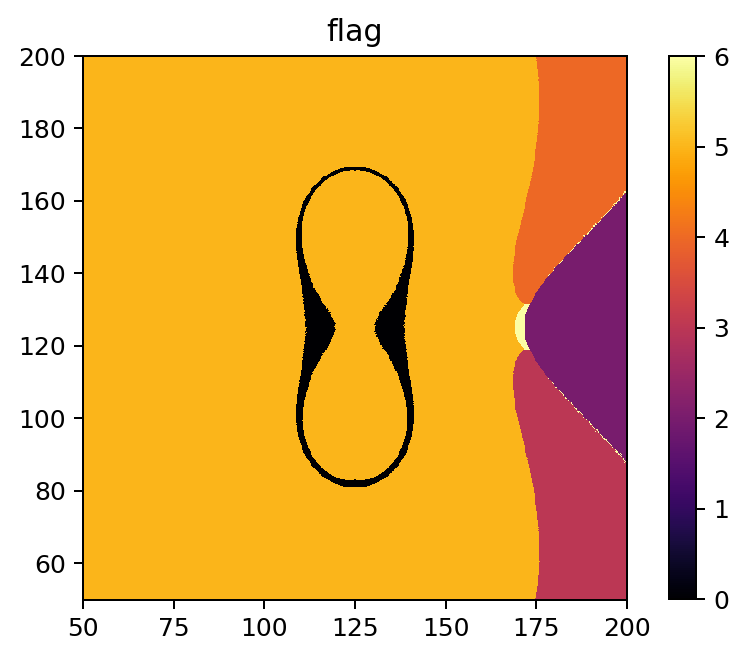

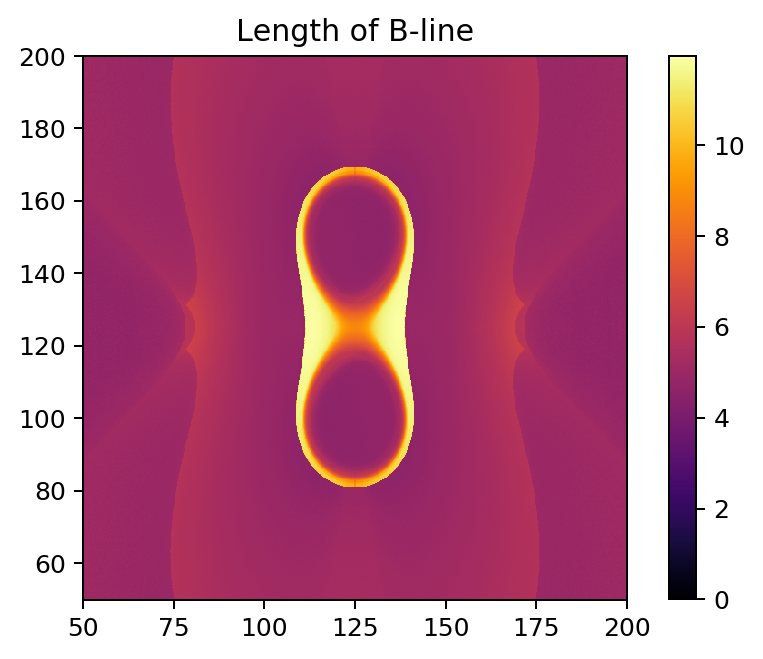

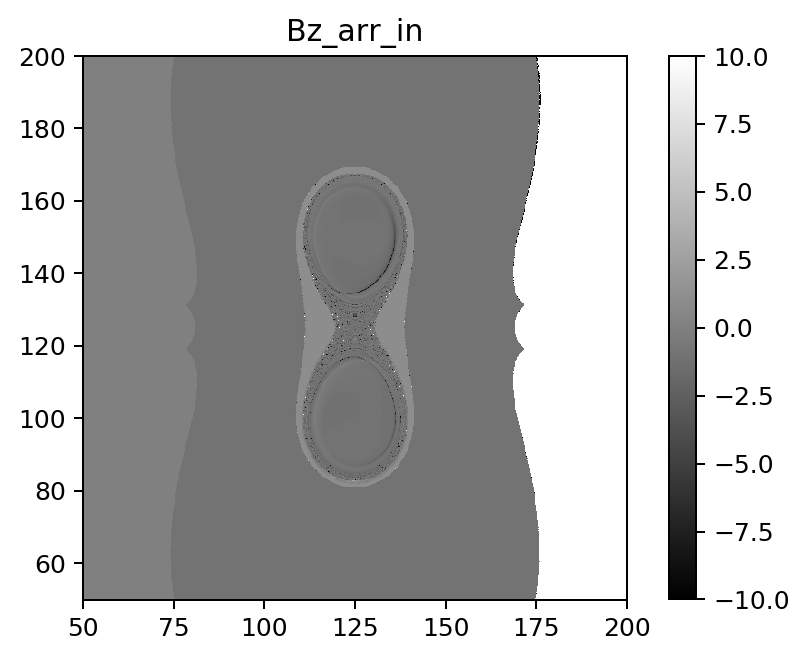

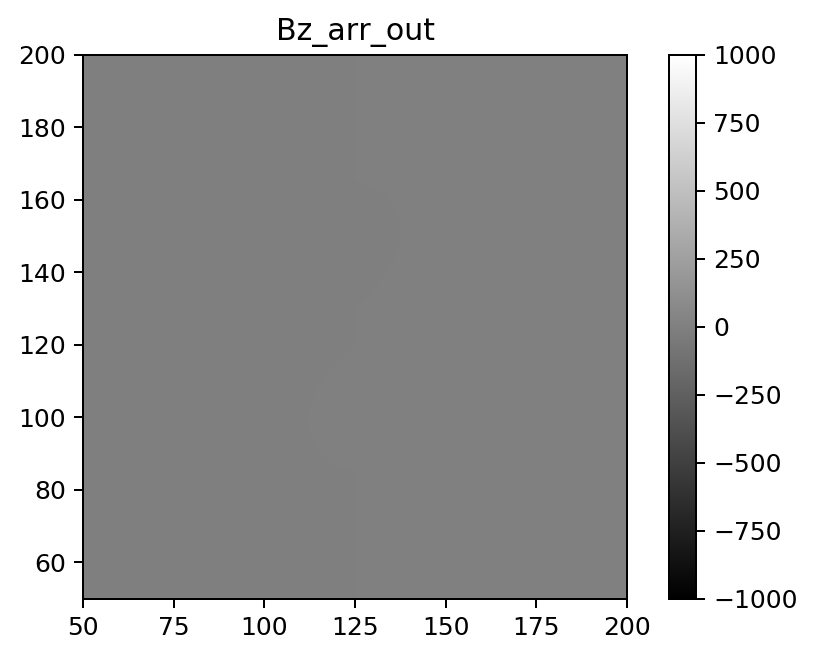

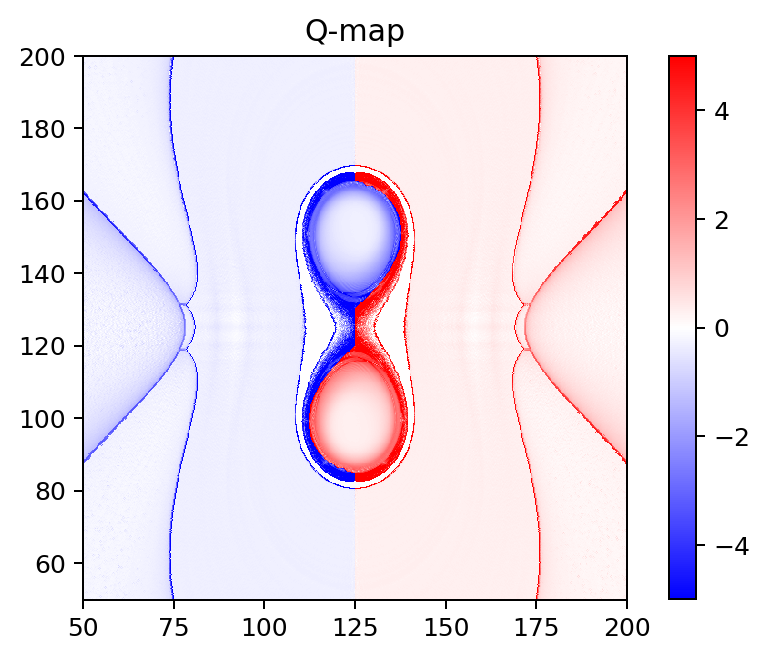

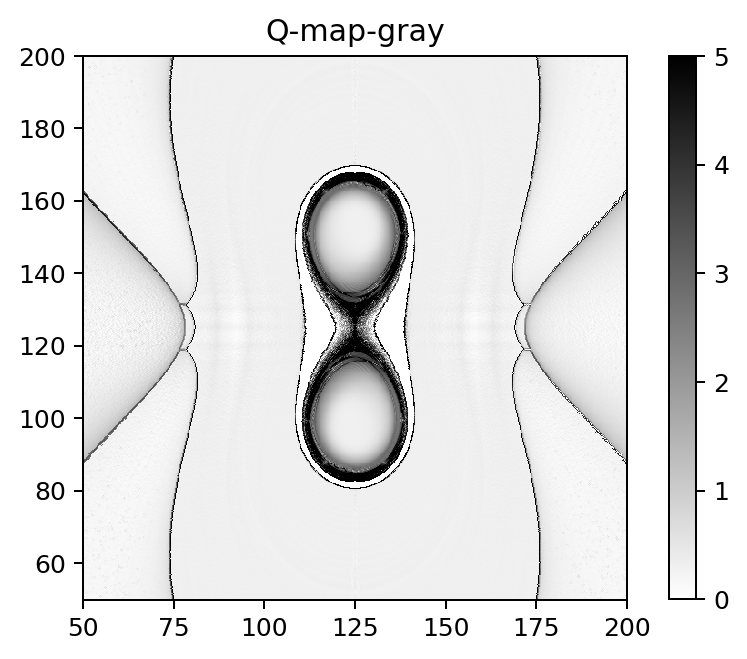

time: 3.04 s


In [39]:
plt.close()

xxlim=None
yylim=None

#xxlim=[400,510]
#yylim=[300,380]
#xxlim=[400,650]
#yylim=[200,380]

dpi=180

fig=plt.figure(0,dpi=dpi); ax = plt.gca() 
img=ax.imshow(flags_arr.get(),cmap='inferno',origin='lower',vmin=0,
              extent=[*x_range,*y_range],vmax=6)
fig.colorbar(img)
ax.set_title('flag')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(1,dpi=dpi); ax = plt.gca() 
img=ax.imshow(np.log(line_len.get().reshape(xy_shape)),cmap='inferno',origin='lower',
              vmin=0,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Length of B-line')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_in_z.get()/Bz_arr_out_z.get(),cmap='gray',origin='lower',
              vmax=10,vmin=-10,extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_in')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=dpi); ax = plt.gca() 
img=ax.imshow(Bz_arr_0_z.get(),cmap='gray',origin='lower',vmax=1000,vmin=-1000,
              extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Bz_arr_out')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(4,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*np.sign(Bz_arr_0_z.get()[1:-1,1:-1])*(flags_arr.get()[1:-1,1:-1]<np.inf),
                vmax=5,vmin=-5,cmap='bwr',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('Q-map')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


fig=plt.figure(5,dpi=dpi); ax = plt.gca() 
img = ax.imshow(np.log10(Q.get())*(flags_arr.get()[1:-1,1:-1]<41),
                vmax=5,vmin=0,cmap='gray_r',origin='lower',extent=[*x_range,*y_range])
#ax.contour(flags_arr,origin='lower',extent=[*x_range,*y_range])

fig.colorbar(img)
ax.set_title('Q-map-gray')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)




<ipython-input-32-747b049313af>:2: RuntimeWarning: divide by zero encountered in log
  img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])


(50.0, 200.0)

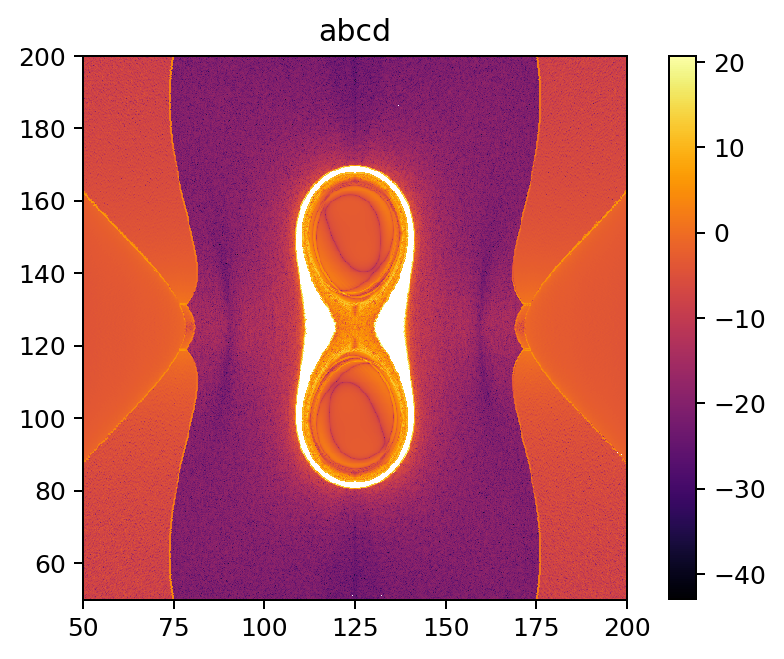

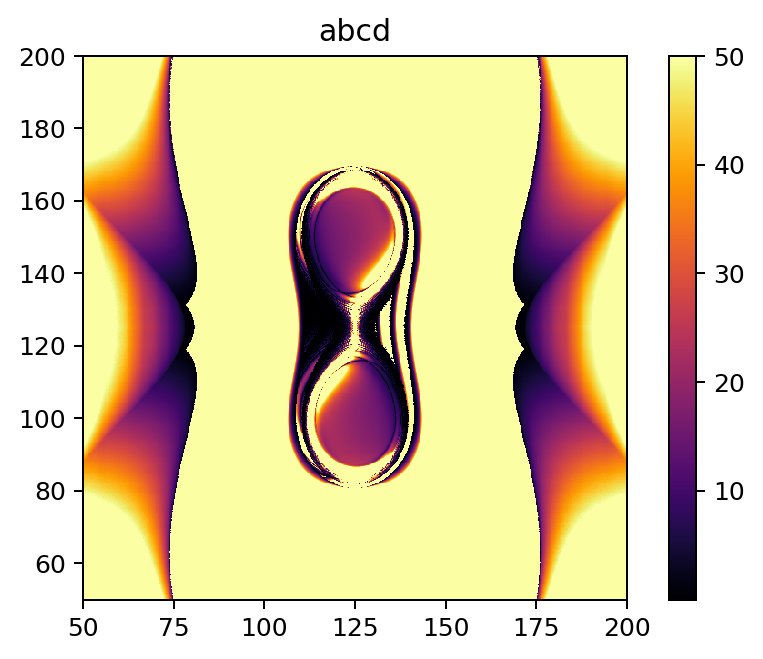

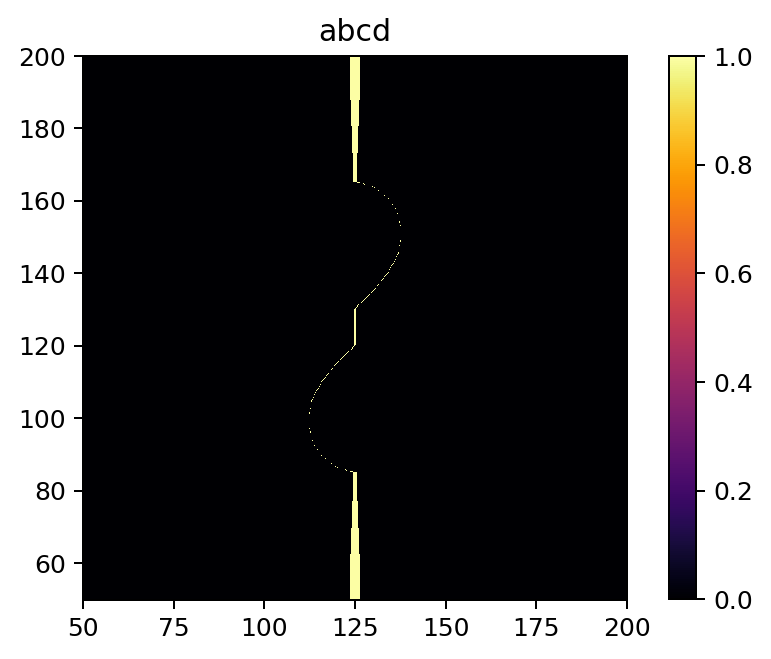

time: 1.5 s


In [32]:
fig=plt.figure(1,dpi=180); ax = plt.gca() 
img = ax.imshow(np.log((b.get())**2),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(2,dpi=180); ax = plt.gca() 
img = ax.imshow((bnr.get()),vmax=50,cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)

fig=plt.figure(3,dpi=180); ax = plt.gca() 
img = ax.imshow((B_flag_arr.get()),cmap='inferno',origin='lower',extent=[*x_range,*y_range])
fig.colorbar(img)
ax.set_title('abcd')
ax.set_xlim(xxlim)
ax.set_ylim(yylim)


Text(0.5, 1.0, 'Length histogram')

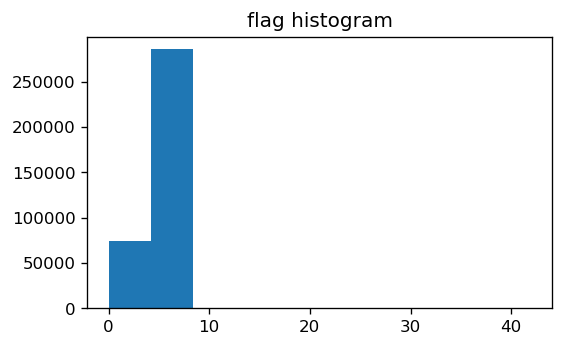

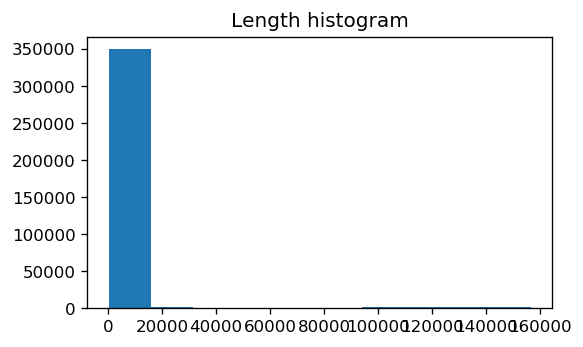

time: 443 ms


In [33]:

plt.figure(10,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(flag_start.get())
ax.set_title('flag histogram')

plt.figure(11,figsize=[5,3],dpi=120); ax = plt.gca() 
plt.hist(line_len.get())
ax.set_title('Length histogram')

In [ ]:
flags_arr